In [1]:
import requests
import pandas as pd
from typing import Dict, List
from dataclasses import dataclass
from datetime import datetime
import json
import matplotlib.pyplot as plt
from web3 import Web3, HTTPProvider
import dotenv
import os
import numpy as np


---

In [2]:
@dataclass
class TokenInfo:
    symbol: str
    address: str

@dataclass
class MarketInfo:
    address: str
    factory_address: str
    llamma: str
    rate: float
    total_debt: float
    n_loans: int
    debt_ceiling: float
    borrowable: float
    pending_fees: float
    collected_fees: float
    collateral_amount: float
    collateral_amount_usd: float
    stablecoin_amount: float
    collateral_token: TokenInfo
    stablecoin_token: TokenInfo
    


def fetch_curve_markets(chain: str = "ethereum", page: int = 1, per_page: int = 10) -> Dict:
    """
    Fetch crvUSD market data from Curve API
    """
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}"
    params = {
        "fetch_on_chain": "false",
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()  # Raise exception for bad status codes
    return response.json()

def parse_market_data(market_data: Dict) -> MarketInfo:
    """
    Parse raw market data into MarketInfo object
    """
    
    w3 = Web3()
    
    return MarketInfo(
        address=w3.to_checksum_address(market_data["address"]),
        factory_address=w3.to_checksum_address(market_data["factory_address"]),
        llamma=w3.to_checksum_address(market_data["llamma"]),
        rate=market_data["rate"],
        total_debt=market_data["total_debt"],
        n_loans=market_data["n_loans"],
        debt_ceiling=market_data["debt_ceiling"],
        borrowable=market_data["borrowable"],
        pending_fees=market_data["pending_fees"],
        collected_fees=market_data["collected_fees"],
        collateral_amount=market_data["collateral_amount"],
        collateral_amount_usd=market_data["collateral_amount_usd"],
        stablecoin_amount=market_data["stablecoin_amount"],
        collateral_token=TokenInfo(
            symbol=market_data["collateral_token"]["symbol"],
            address=w3.to_checksum_address(market_data["collateral_token"]["address"])
        ),
        stablecoin_token=TokenInfo(
            symbol=market_data["stablecoin_token"]["symbol"],
            address=w3.to_checksum_address(market_data["stablecoin_token"]["address"])
        )
    )

def get_markets_df() -> pd.DataFrame:
    """
    Fetch market data and return as a pandas DataFrame
    """
    raw_data = fetch_curve_markets()
    markets = [parse_market_data(market) for market in raw_data["data"]]
    
    # Convert to dictionary format suitable for DataFrame
    markets_dict = {
        "address": [],
        "collateral_token": [],
        "rate": [],
        "total_debt": [],
        "n_loans": [],
        "borrowable": [],
        "collateral_amount": [],
        "collateral_amount_usd": [],
        "pending_fees": [],
        "collected_fees": []
    }
    
    for market in markets:
        markets_dict["address"].append(market.address)
        markets_dict["collateral_token"].append(market.collateral_token.symbol)
        markets_dict["rate"].append(market.rate)
        markets_dict["total_debt"].append(market.total_debt)
        markets_dict["n_loans"].append(market.n_loans)
        markets_dict["borrowable"].append(market.borrowable)
        markets_dict["collateral_amount"].append(market.collateral_amount)
        markets_dict["collateral_amount_usd"].append(market.collateral_amount_usd)
        markets_dict["pending_fees"].append(market.pending_fees)
        markets_dict["collected_fees"].append(market.collected_fees)
    
    return pd.DataFrame(markets_dict)

def get_markets_map() -> Dict[str, MarketInfo]:
    """
    Fetch market data and return as a dictionary mapping addresses to MarketInfo objects
    """
    raw_data = fetch_curve_markets()
    markets_map = {}
    
    for market in raw_data["data"]:
        if market["borrowable"] != 0:
            markets_map[market["collateral_token"]["symbol"]] = parse_market_data(market)

    return markets_map


markets = get_markets_map()

In [3]:
# Fix to:
ABI = [{"inputs":[{"name":"controller","type":"address"}],
        "name":"get_debt_stats",
        "outputs":[{"name":"","type":"uint256"},
                  {"name":"","type":"uint256"},
                  {"name":"","type":"uint256"}],
        "stateMutability":"view",
        "type":"function"}]  
# Single set of brackets
DATA_ADDRESS = "0x76052439A4a632B65Cc03074DF1C7766BA0E0471"

dotenv.load_dotenv()

RPC_URL = os.getenv("RPC_ETH")

def get_hhi(controller_address: str, block_number=None):
    try:
        W3 = Web3(HTTPProvider(RPC_URL))
        contract = W3.eth.contract(address=Web3.to_checksum_address(DATA_ADDRESS), abi=ABI)
        contract_function = getattr(contract.functions, "get_debt_stats")
        
        if block_number is not None:
            data = contract_function(Web3.to_checksum_address(controller_address)).call(block_identifier=int(block_number))
        else:
            data = contract_function(Web3.to_checksum_address(controller_address)).call()
        
        output = {}
        output["hhi_actual"] = data[2]/10**36
        output["hhi_ideal"] = data[1]/(data[0]*10**36)
        output["hhi_ratio"] = output["hhi_actual"]/output["hhi_ideal"]
        
        return output, output["hhi_ratio"]
    except Exception as e:
        raise Exception(f'Error querying smart contract: {e}')
    
    
def get_hhi_historic(controller_address: str, block_numbers: List[int]):
    hhi_list = []
    
    for block_number in block_numbers:
        
        hhi_list_dict = {}
        hhi_list_dict["block_number"] = block_number
        
        hhi_output, hhi_ratio = get_hhi(controller_address, block_number)
        hhi_list_dict["hhi_actual"] = hhi_output["hhi_actual"]
        hhi_list_dict["hhi_ideal"] = hhi_output["hhi_ideal"]
        hhi_list_dict["hhi_ratio"] = hhi_ratio
        
        hhi_list.append(hhi_list_dict)
    
    hhi_df = pd.DataFrame(hhi_list)
    
    return hhi_df

def generate_block_list(period_hours: int, length: int) -> list:
    """
    Generate a list of block numbers based on period and length.
    
    Parameters:
    -----------
    period_hours : int
        Period in hours between each block number
    length : int
        Length of the list to generate
    
    Returns:
    --------
    list
        List of block numbers
    """
    try:
        # Connect to Ethereum node
        w3 = Web3(HTTPProvider(os.getenv("RPC_ETH")))
        
        # Get current block number
        current_block = w3.eth.block_number
        
        # Calculate blocks per period
        # 1 block = 12 seconds
        # blocks per hour = (60 * 60) / 12 = 300
        blocks_per_period = (period_hours * 60 * 60) // 12
        
        # Generate list of block numbers
        block_list = [
            current_block - (blocks_per_period * i)
            for i in range(length)
        ]
        
        # Return reversed list so it's in chronological order
        return list(reversed(block_list))
    
    except Exception as e:
        raise Exception(f'Error generating block list: {e}')

---

In [4]:
CONTROLLER_ADDRESS = "0x100daa78fc509db39ef7d04de0c1abd299f4c6ce"


In [5]:
def get_market_snapshots(controller_address: str, 
                         chain: str = "ethereum") -> pd.DataFrame:
    """
    Fetch historical snapshots for a specific crvUSD market
    
    Parameters:
    -----------
    market_obj : Market
        The market address to fetch snapshots for
    chain : str
        The blockchain network (default: "ethereum")
    agg : str
        Aggregation period - 'day' or 'hour' (default: "day")
    """
    
    url = f"https://prices.curve.fi/v1/crvusd/markets/{chain}/{controller_address}/snapshots"
    params = {
        "fetch_on_chain": "false",
        "agg": "none"
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json()['data'])
    
    # Process DataFrame
    if not df.empty:
        # Convert timestamp to datetime
        df['dt'] = pd.to_datetime(df['dt'])
        df.set_index('dt', inplace=True)
        
        # Convert scientific notation columns to float
        scientific_columns = ['loan_discount', 'liquidation_discount']
        for col in scientific_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by date ascending
        df.sort_index(inplace=True)
    
    df["hhi"] = df["sum_debt_squared"]
    df["hhi_ideal"] = (df["total_debt"]**2)/df["n_loans"]
    df["hhi_ratio"] = df["hhi"]/df["hhi_ideal"]
    
    return df

def calculate_hhi_limits(latest_row: dict, 
                         top_proportion_loans: float, 
                         max_debt_proportion: float) -> dict:
    """
    Calculate HHI upper limit based on loan proportions and debt distribution.
    
    Parameters:
    -----------
    latest_row : dict
        Dictionary containing market metrics including total_debt and n_loans
    top_proportion_loans : float
        Proportion of loans considered "top" (between 0 and 1)
    max_debt_proportion : float
        Maximum proportion of debt (between 0 and 1)
    
    Returns:
    --------
    dict
        Dictionary containing HHI upper limit and actual HHI
    """
    # Calculate component A: distribution for non-top loans
    A = (((1 - max_debt_proportion) * latest_row['total_debt'])**2) / \
        ((1 - top_proportion_loans) * latest_row['n_loans'])
    
    # Calculate component B: distribution for top loans
    B = ((max_debt_proportion * latest_row['total_debt'])**2) / \
        (top_proportion_loans * latest_row['n_loans'])
    
    # Calculate HHI upper limit
    hhi_upper_limit = A + B
    
    return {
        'hhi_upper_limit': hhi_upper_limit,
        'hhi_actual': latest_row['hhi'],
        'hhi_ideal': latest_row['hhi_ideal'],
        'hhi_ratio_actual': latest_row['hhi_ratio'],
        'hhi_ratio_upper_limit': hhi_upper_limit/latest_row['hhi_ideal']
    }
    
def calculate_hhi_limits_for_df(df: pd.DataFrame, top_proportion_loans: float = 0.05, max_debt_proportion: float = 0.9) -> pd.DataFrame:
    """
    Calculate HHI upper limits for each row in the DataFrame
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing market metrics
    top_proportion_loans : float
        Proportion of loans considered "top" (default: 0.05)
    max_debt_proportion : float
        Maximum proportion of debt (default: 0.9)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added HHI upper limit columns
    """
    # Create copy to avoid modifying original
    df = df.copy()
    
    # Calculate for each row
    df['hhi_upper_limit'] = df.apply(lambda row: (
        ((1 - max_debt_proportion) * row['total_debt'])**2 / ((1 - top_proportion_loans) * row['n_loans']) +
        (max_debt_proportion * row['total_debt'])**2 / (top_proportion_loans * row['n_loans'])
    ), axis=1)
    
    # Calculate ratio
    df['hhi_ratio_upper_limit'] = df['hhi_upper_limit'] / df['hhi_ideal']
    
    return df

wstETH | 25.37478284403603


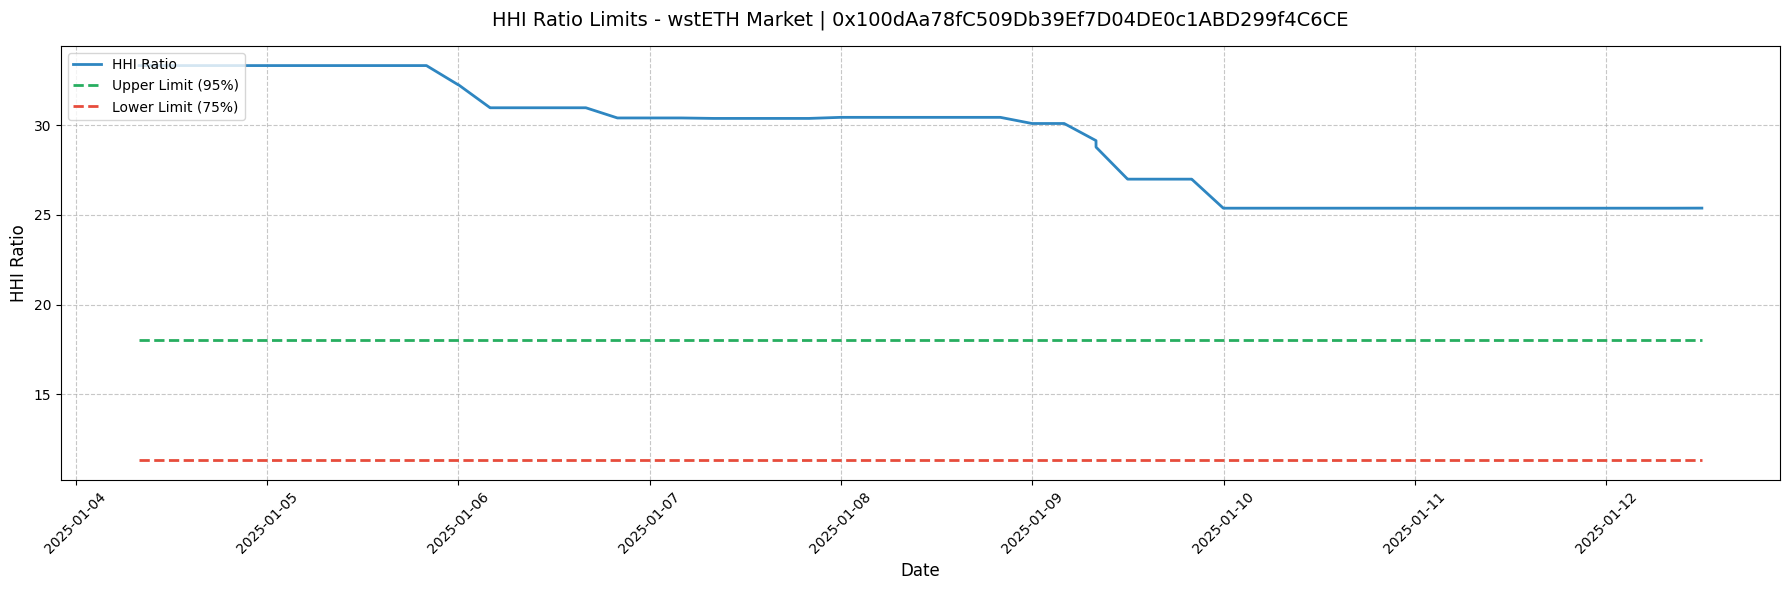

WBTC | 12.574399263663771


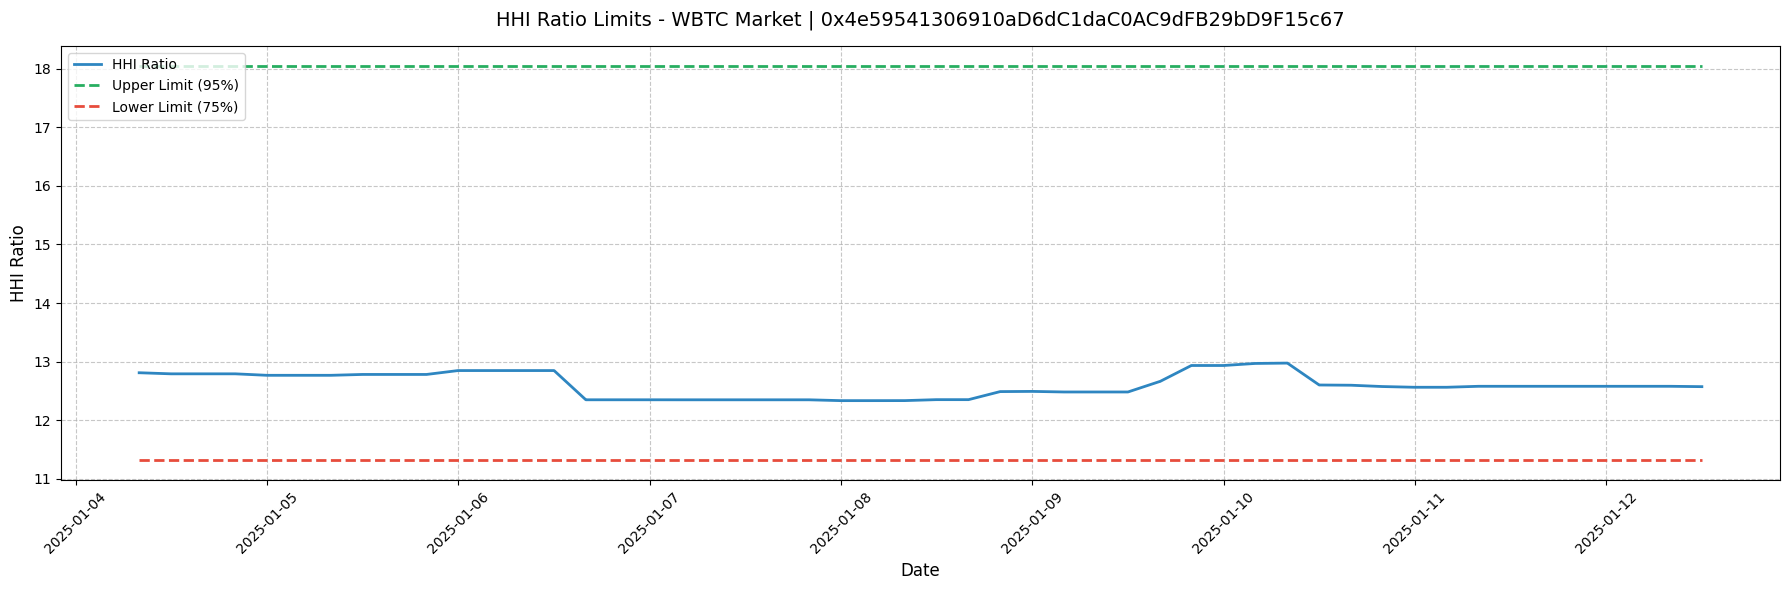

WETH | 15.772857059975749


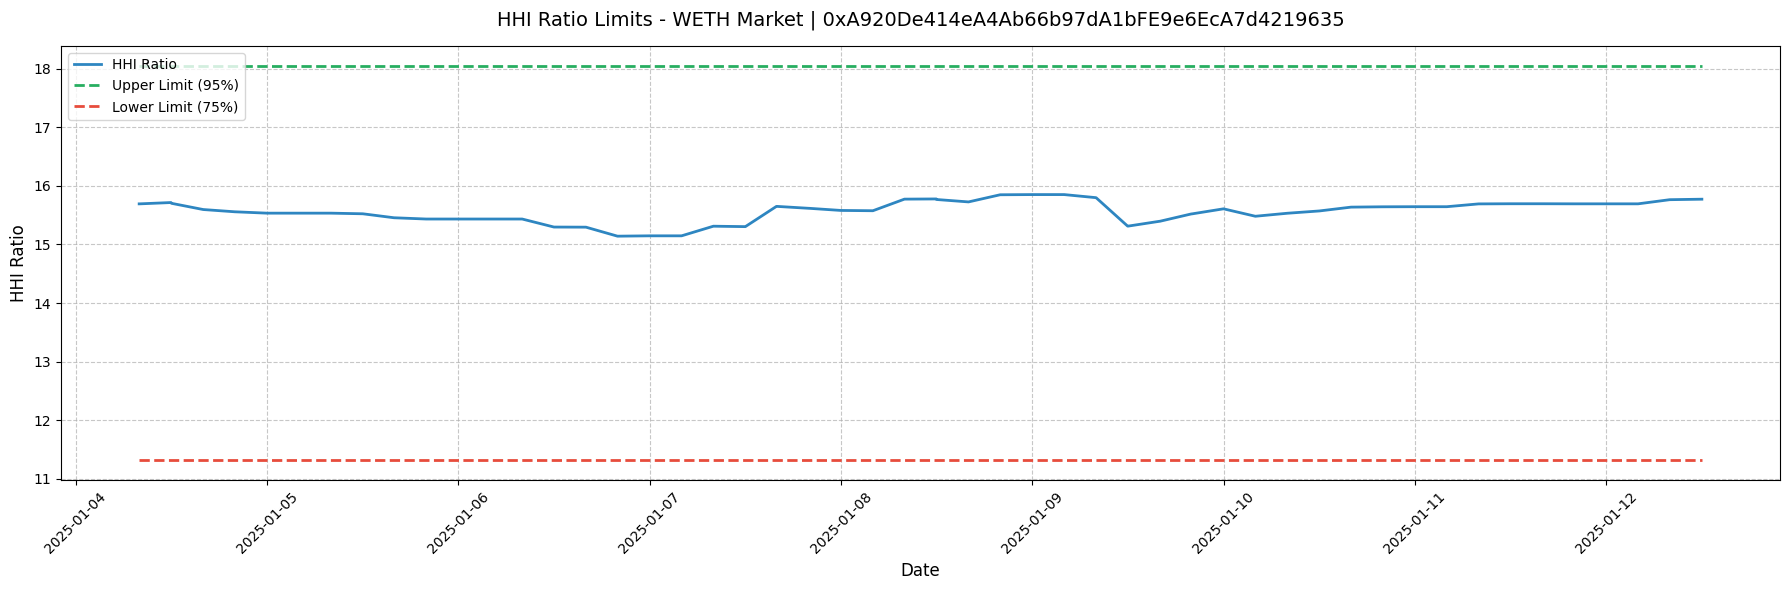

sfrxETH | 2.440877372481856


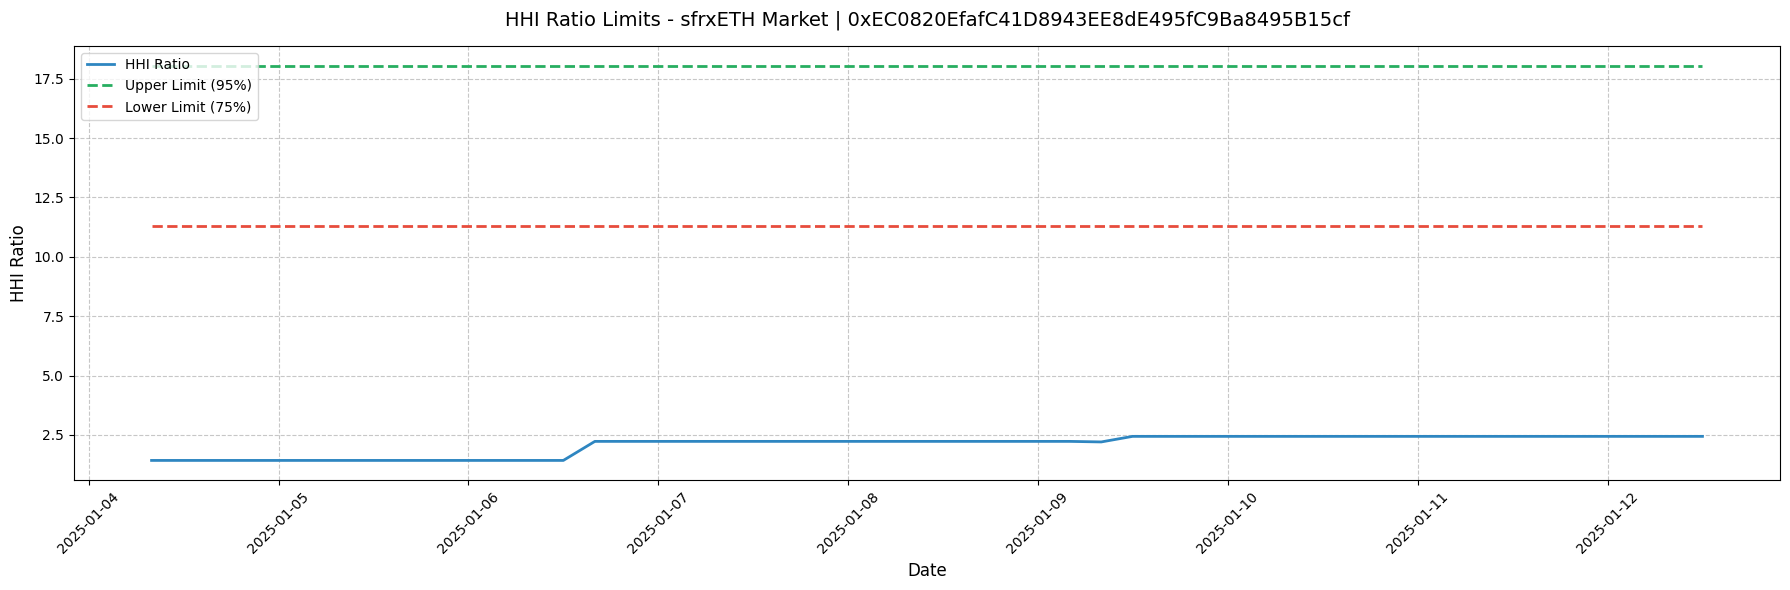

tBTC | 2.4650601370575482


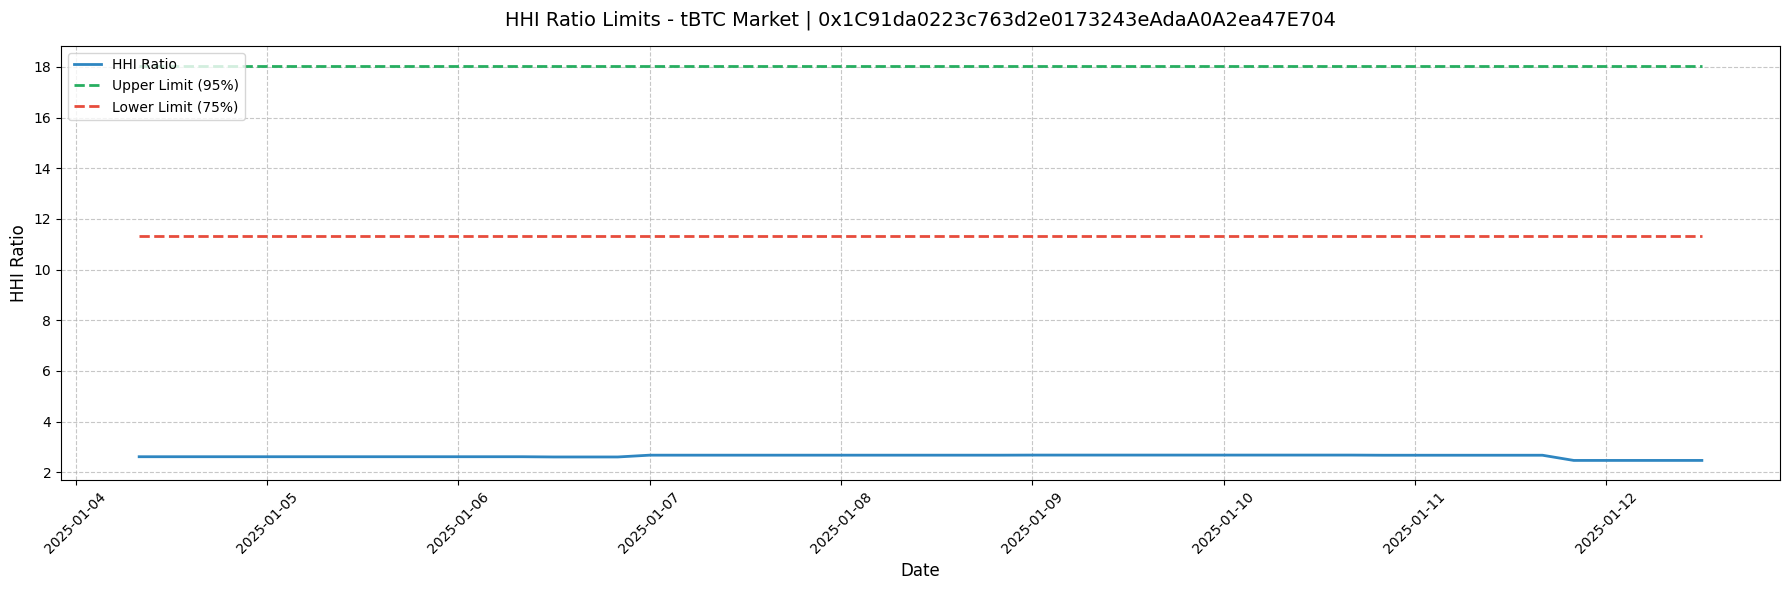

In [6]:
for market in markets:
    name = market
    df = get_market_snapshots(markets[market].address)
    
    print(f"{name} | {df.iloc[-1]['hhi_ratio']}")
    
    # Calculate HHI limits
    df_upper = calculate_hhi_limits_for_df(df, 0.05, 0.95)
    df_lower = calculate_hhi_limits_for_df(df, 0.05, 0.75)
    
    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(18, 6))
    
    # Plot HHI ratios on primary axis
    color1 = '#2E86C1'  # Blue for actual ratio
    color_upper = '#27AE60'  # Green for upper limit
    color_lower = '#E74C3C'  # Red for lower limit
    
    # Plot actual HHI ratio
    ax1.plot(df.index, df["hhi_ratio"], 
             linewidth=2, color=color1, label='HHI Ratio')
    
    # Plot upper and lower limits
    ax1.plot(df.index, df_upper["hhi_ratio_upper_limit"], 
             linewidth=2, color=color_upper, linestyle='--', label='Upper Limit (95%)')
    ax1.plot(df.index, df_lower["hhi_ratio_upper_limit"], 
             linewidth=2, color=color_lower, linestyle='--', label='Lower Limit (75%)')
    
    # Labels and formatting
    ax1.set_xlabel('Date', fontsize=12)
    ax1.set_ylabel('HHI Ratio', fontsize=12)
    plt.title(f'HHI Ratio Limits - {name} Market | {markets[market].address}', fontsize=14, pad=15)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    
    # Add legend
    ax1.legend(loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()

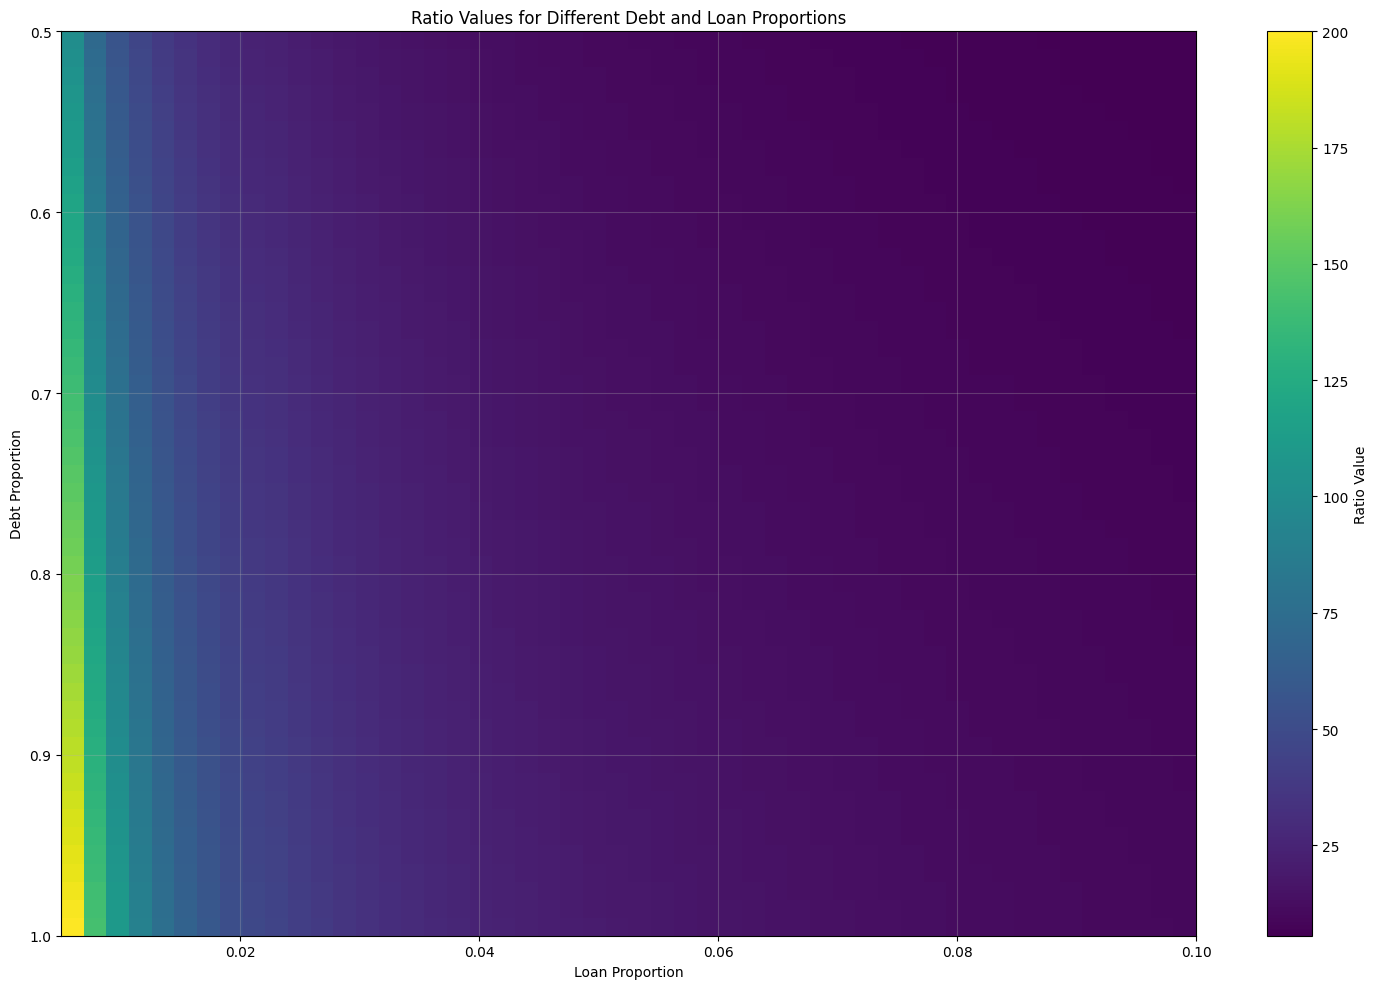

In [7]:
def analyze_ratio_combinations(steps: int = 50):
    """
    Analyze different combinations of debt and loan proportions and their resulting ratios.
    """
    # Create grid of values
    debt_props = np.round(np.linspace(0.5, 1.0, steps), 3)
    loan_props = np.round(np.linspace(0.005, 0.1, steps), 3)
    
    # Create a 2D array for the heatmap
    ratios = np.zeros((steps, steps))
    
    # Calculate ratios for each combination
    for i, debt_prop in enumerate(debt_props):
        for j, loan_prop in enumerate(loan_props):
            ratio = round(((1-debt_prop)/(1-loan_prop))+(debt_prop/loan_prop), 3)
            ratios[i][j] = ratio
    
    return debt_props, loan_props, ratios

def plot_ratio_heatmap(debt_props, loan_props, ratios):
    """
    Create a heatmap visualization of the ratios.
    """
    plt.figure(figsize=(15, 10))
    
    # Create heatmap
    im = plt.imshow(ratios, 
                    cmap='viridis',
                    aspect='auto',
                    extent=[min(loan_props), max(loan_props), 
                           max(debt_props), min(debt_props)])  # Note: reversed debt_props for correct orientation
    
    # Add colorbar and labels
    cbar = plt.colorbar(im, label='Ratio Value')
    plt.xlabel('Loan Proportion')
    plt.ylabel('Debt Proportion')
    plt.title('Ratio Values for Different Debt and Loan Proportions')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Generate and plot the data
debt_props, loan_props, ratios = analyze_ratio_combinations()
plot_ratio_heatmap(debt_props, loan_props, ratios)

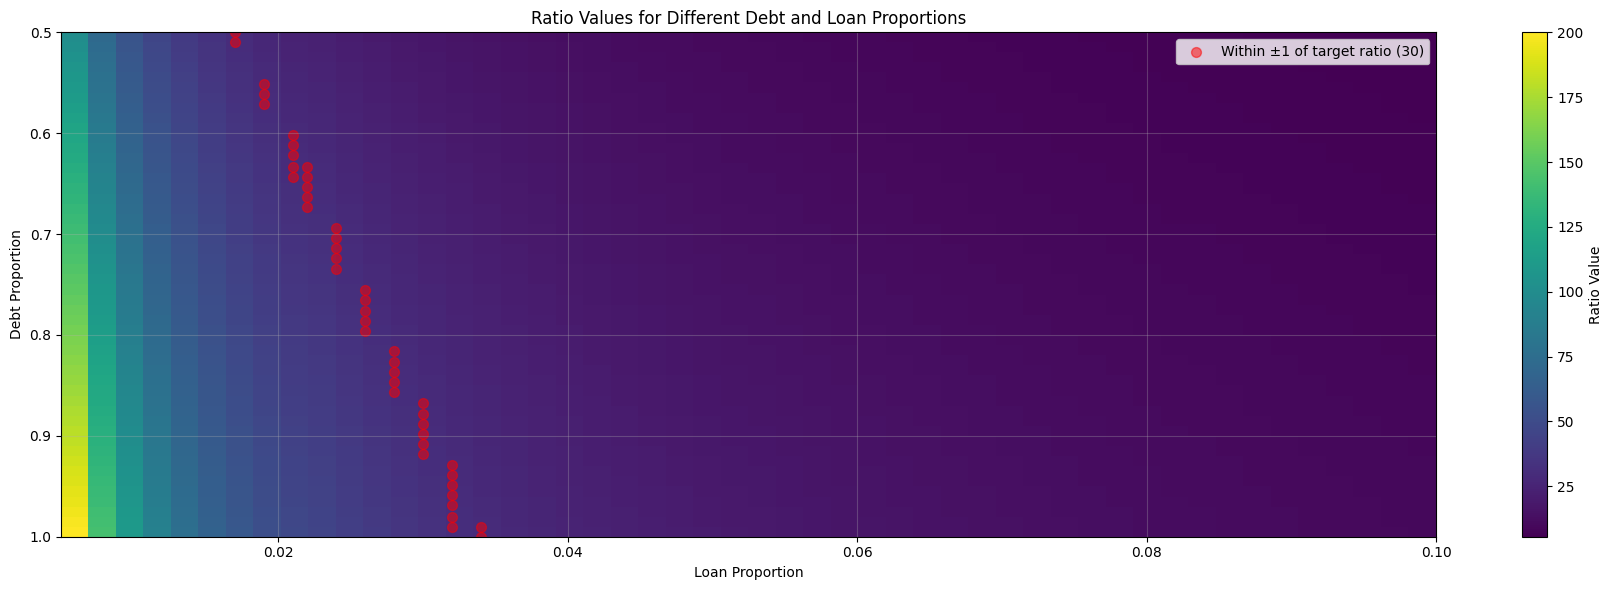

In [8]:
def analyze_ratio_combinations(steps: int = 50):
    """
    Analyze different combinations of debt and loan proportions and their resulting ratios.
    """
    # Create grid of values
    debt_props = np.round(np.linspace(0.5, 1.0, steps), 3)
    loan_props = np.round(np.linspace(0.005, 0.1, steps), 3)
    
    # Create a 2D array for the heatmap
    ratios = np.zeros((steps, steps))
    
    # Calculate ratios for each combination
    for i, debt_prop in enumerate(debt_props):
        for j, loan_prop in enumerate(loan_props):
            ratio = round(((1-debt_prop)/(1-loan_prop))+(debt_prop/loan_prop), 3)
            ratios[i][j] = ratio
    
    return debt_props, loan_props, ratios

def plot_ratio_heatmap(debt_props, loan_props, ratios, target_ratio: float = 20, tolerance: float = 0.5):
    """
    Create a heatmap visualization of the ratios with highlighted target areas.
    
    Parameters:
    -----------
    debt_props, loan_props, ratios : array-like
        The data for the heatmap
    target_ratio : float
        The ratio value to highlight
    tolerance : float
        How close to the target ratio should points be to get highlighted
    """
    plt.figure(figsize=(18, 6))
    
    # Create heatmap
    im = plt.imshow(ratios, 
                    cmap='viridis',
                    aspect='auto',
                    extent=[min(loan_props), max(loan_props), 
                           max(debt_props), min(debt_props)])
    
    # Find points near target ratio
    target_points = []
    for i, debt_prop in enumerate(debt_props):
        for j, loan_prop in enumerate(loan_props):
            if abs(ratios[i][j] - target_ratio) <= tolerance:
                target_points.append((loan_prop, debt_prop))
    
    if target_points:
        # Separate x and y coordinates
        x_coords, y_coords = zip(*target_points)
        plt.scatter(x_coords, y_coords, 
                   color='red', 
                   s=50, 
                   alpha=0.5,
                   label=f'Within ±{tolerance} of target ratio ({target_ratio})')
    
    # Add colorbar and labels
    cbar = plt.colorbar(im, label='Ratio Value')
    plt.xlabel('Loan Proportion')
    plt.ylabel('Debt Proportion')
    plt.title('Ratio Values for Different Debt and Loan Proportions')
    
    # Add grid and legend
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Generate and plot the data
debt_props, loan_props, ratios = analyze_ratio_combinations()
plot_ratio_heatmap(debt_props, loan_props, ratios, target_ratio=30, tolerance=1)

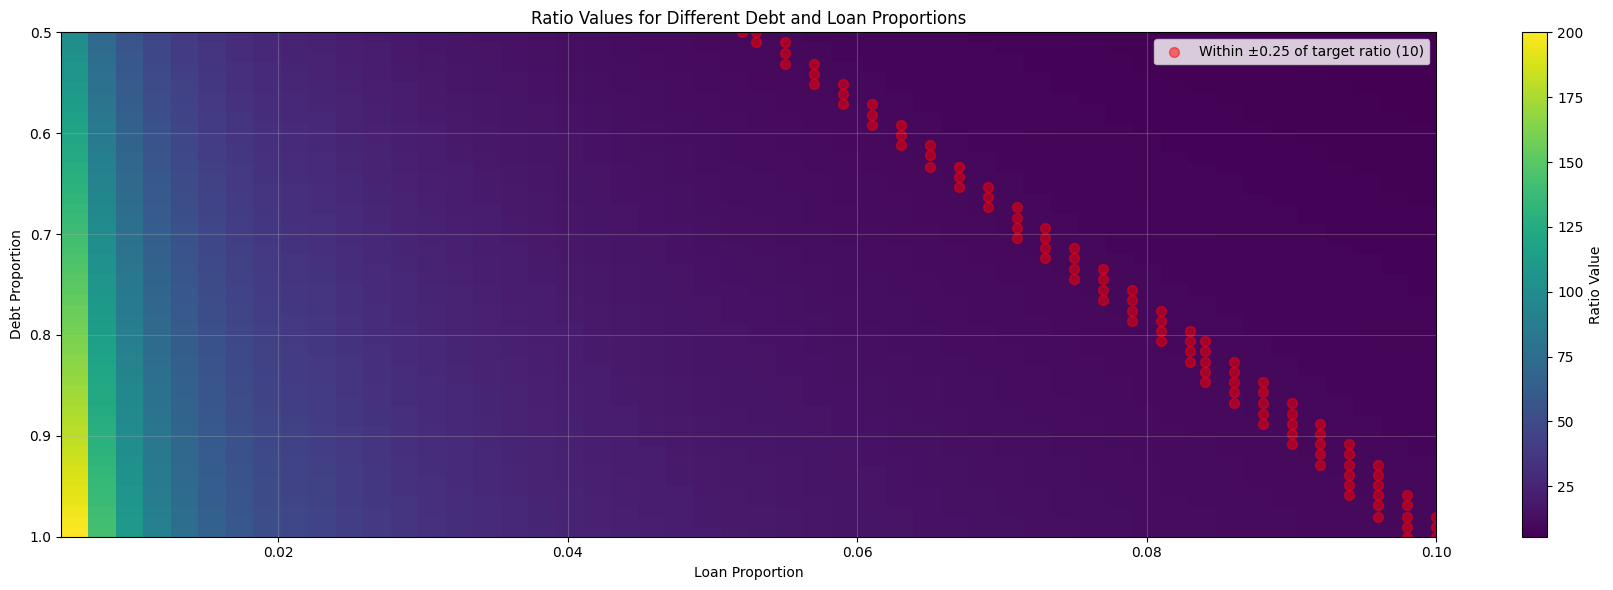

In [9]:
plot_ratio_heatmap(debt_props, loan_props, ratios, target_ratio=10, tolerance=0.25)

### 10 - 30 Range

---

In [10]:
for market in markets:
    name = market
    hhi = get_hhi(markets[market].address)
    print(f"{name} | address: {markets[market].address} | hhi_ratio: {hhi[0]['hhi_ratio']} | hhi: {hhi[0]['hhi_actual']}")

wstETH | address: 0x100dAa78fC509Db39Ef7D04DE0c1ABD299f4C6CE | hhi_ratio: 25.37478284403603 | hhi: 107602690339679.31
WBTC | address: 0x4e59541306910aD6dC1daC0AC9dFB29bD9F15c67 | hhi_ratio: 12.574399263663773 | hhi: 32284960020906.004
WETH | address: 0xA920De414eA4Ab66b97dA1bFE9e6EcA7d4219635 | hhi_ratio: 15.772857059975752 | hhi: 43517272160965.64
sfrxETH | address: 0xEC0820EfafC41D8943EE8dE495fC9Ba8495B15cf | hhi_ratio: 2.4408773724818564 | hhi: 31354976637.178425
tBTC | address: 0x1C91da0223c763d2e0173243eAdaA0A2ea47E704 | hhi_ratio: 2.4650601370575487 | hhi: 6102405061114.468


---

In [11]:
CONTROLLER_ADDRESS = "0x100daa78fc509db39ef7d04de0c1abd299f4c6ce"

In [12]:
df = get_market_snapshots(CONTROLLER_ADDRESS)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2025-01-04 07:56:59 to 2025-01-12 12:00:11
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   rate                  100 non-null    float64
 1   minted                100 non-null    float64
 2   redeemed              100 non-null    float64
 3   total_collateral      100 non-null    float64
 4   total_collateral_usd  100 non-null    float64
 5   total_stablecoin      100 non-null    float64
 6   total_debt            100 non-null    float64
 7   n_loans               100 non-null    int64  
 8   amm_price             100 non-null    float64
 9   price_oracle          100 non-null    float64
 10  base_price            100 non-null    float64
 11  min_band              100 non-null    int64  
 12  max_band              100 non-null    int64  
 13  borrowable            100 non-null    float64
 14  loan_discount         100 non-null   

In [13]:
# Get row dictionary for the latest row
latest_row = df.iloc[-1].to_dict()
latest_row

{'rate': 0.07035060980774377,
 'minted': 351614229.13355106,
 'redeemed': 332535248.69229764,
 'total_collateral': 7689.747122719911,
 'total_collateral_usd': 29739692.90881451,
 'total_stablecoin': 0.017598543792083726,
 'total_debt': 19096482.887016036,
 'n_loans': 86.0,
 'amm_price': 3671.856344656012,
 'price_oracle': 3867.447451028194,
 'base_price': 2602.2924889987744,
 'min_band': -57.0,
 'max_band': 1034.0,
 'borrowable': 130921019.55874656,
 'loan_discount': 9e+16,
 'liquidation_discount': 6e+16,
 'sum_debt_squared': 107599600544808.17,
 'hhi': 107599600544808.17,
 'hhi_ideal': 4240414635512.748,
 'hhi_ratio': 25.37478284403603}

In [14]:
get_hhi(CONTROLLER_ADDRESS)


({'hhi_actual': 107602695906917.31,
  'hhi_ideal': 4240536621270.3467,
  'hhi_ratio': 25.37478284403603},
 25.37478284403603)

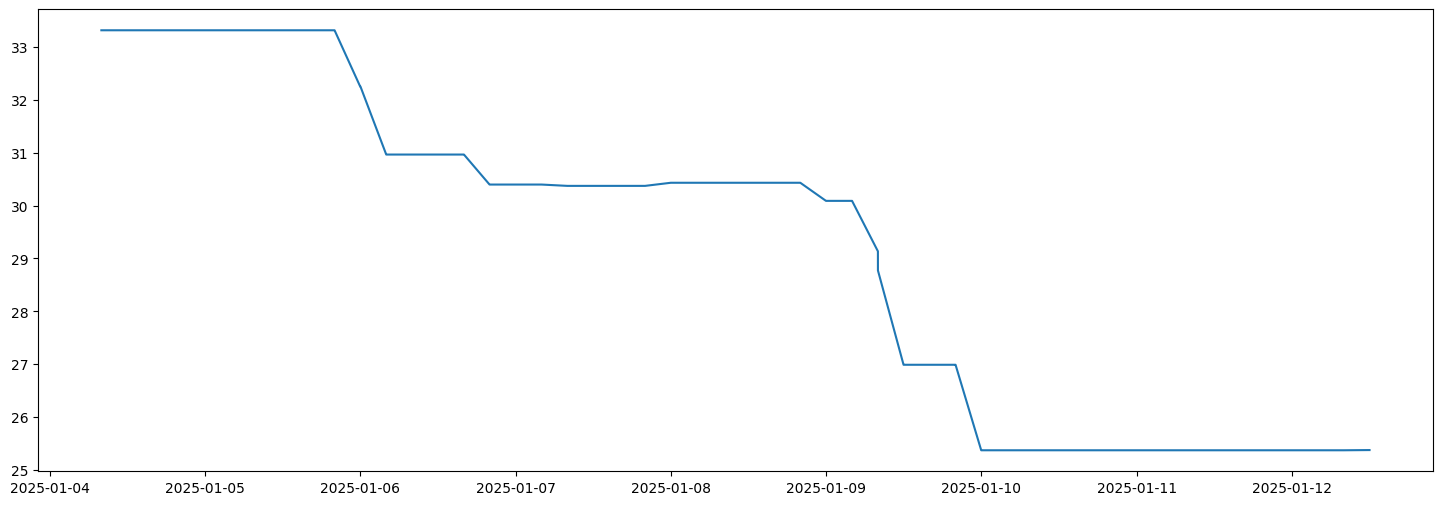

In [15]:
# WBTC
plt.figure(figsize=(18, 6))
plt.plot(df.index, df["hhi_ratio"])
plt.show()

In [16]:
# # WBTC
# plt.figure(figsize=(18, 6))
# plt.plot(df.index, df["hhi_ratio"])
# plt.show()

In [17]:
def calculate_hhi_limits(latest_row: dict, 
                         top_proportion_loans: float, 
                         max_debt_proportion: float) -> dict:
    """
    Calculate HHI upper limit based on loan proportions and debt distribution.
    
    Parameters:
    -----------
    latest_row : dict
        Dictionary containing market metrics including total_debt and n_loans
    top_proportion_loans : float
        Proportion of loans considered "top" (between 0 and 1)
    max_debt_proportion : float
        Maximum proportion of debt (between 0 and 1)
    
    Returns:
    --------
    dict
        Dictionary containing HHI upper limit and actual HHI
    """
    # Calculate component A: distribution for non-top loans
    A = (((1 - max_debt_proportion) * latest_row['total_debt'])**2) / \
        ((1 - top_proportion_loans) * latest_row['n_loans'])
    
    # Calculate component B: distribution for top loans
    B = ((max_debt_proportion * latest_row['total_debt'])**2) / \
        (top_proportion_loans * latest_row['n_loans'])
    
    # Calculate HHI upper limit
    hhi_upper_limit = A + B
    
    return {
        'hhi_upper_limit': hhi_upper_limit,
        'hhi_actual': latest_row['hhi'],
        'hhi_ideal': latest_row['hhi_ideal'],
        'hhi_ratio_actual': latest_row['hhi_ratio'],
        'hhi_ratio_upper_limit': hhi_upper_limit/latest_row['hhi_ideal']
    }

In [18]:
# Extract the most latest row
latest_row = df.iloc[-1]

converted_latest_row = latest_row.to_dict()
converted_latest_row

{'rate': 0.07035060980774377,
 'minted': 351614229.13355106,
 'redeemed': 332535248.69229764,
 'total_collateral': 7689.747122719911,
 'total_collateral_usd': 29739692.90881451,
 'total_stablecoin': 0.017598543792083726,
 'total_debt': 19096482.887016036,
 'n_loans': 86.0,
 'amm_price': 3671.856344656012,
 'price_oracle': 3867.447451028194,
 'base_price': 2602.2924889987744,
 'min_band': -57.0,
 'max_band': 1034.0,
 'borrowable': 130921019.55874656,
 'loan_discount': 9e+16,
 'liquidation_discount': 6e+16,
 'sum_debt_squared': 107599600544808.17,
 'hhi': 107599600544808.17,
 'hhi_ideal': 4240414635512.748,
 'hhi_ratio': 25.37478284403603}

In [19]:
dict_results = calculate_hhi_limits(converted_latest_row, 0.05, 0.9)
dict_results

{'hhi_upper_limit': 68739353038838.24,
 'hhi_actual': 107599600544808.17,
 'hhi_ideal': 4240414635512.748,
 'hhi_ratio_actual': 25.37478284403603,
 'hhi_ratio_upper_limit': 16.210526315789476}

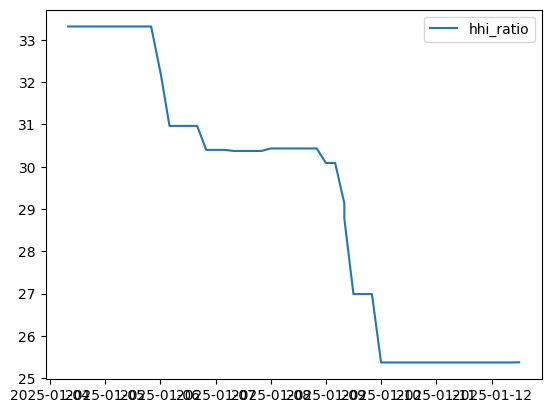

In [20]:
# plot hhi and hhi_ratio
plt.plot(df["hhi_ratio"], label="hhi_ratio")

# plt.plot(df["hhi"], label="hhi")
# plt.plot(df["hhi_ideal"], label="hhi_ideal")
plt.legend()
plt.show()


In [21]:
def get_market_users(controller_address: str, 
                     chain: str = "ethereum",
                     page: int = 1,
                     per_page: int = 300) -> pd.DataFrame:
    """
    Fetch users data for a specific crvUSD market
    
    Parameters:
    -----------
    controller_address : str
        The controller address to fetch users for
    chain : str
        The blockchain network (default: "ethereum")
    page : int
        Page number for pagination (default: 1)
    per_page : int
        Number of results per page (default: 100)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing user data
    """
    
    url = f"https://prices.curve.fi/v1/crvusd/users/{chain}/{controller_address}/users"
    params = {
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json()['data'])
    
    return df

In [22]:
users_df = get_market_users(CONTROLLER_ADDRESS)
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   user    300 non-null    object
 1   first   300 non-null    object
 2   last    300 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [23]:
# First, let's see what we're working with
print("Original data type:", type(users_df['last'].iloc[0]))
print("Sample value:", users_df['last'].iloc[0])

# Convert with explicit format
users_df['last'] = pd.to_datetime(users_df['last'], format='%Y-%m-%dT%H:%M:%S')

# Verify conversion
print("\nAfter conversion:")
print("New data type:", type(users_df['last'].iloc[0]))
print("Sample value:", users_df['last'].iloc[0])

# Now try the 24h filtering
max_date = users_df['last'].max()
users_df_24h = users_df[users_df['last'] >= (max_date - pd.Timedelta(hours=24))]

print("\nDate range:")
print(f"From: {users_df_24h['last'].min()}")
print(f"To: {users_df_24h['last'].max()}")

Original data type: <class 'str'>
Sample value: 2025-01-12T12:00:11

After conversion:
New data type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Sample value: 2025-01-12 12:00:11

Date range:
From: 2025-01-12 12:00:11
To: 2025-01-12 12:00:11


In [24]:
# Convert 'last' column to datetime
users_df['last'] = pd.to_datetime(users_df['last'])

# Get the max date
max_date = users_df['last'].max()

# Filter rows within last 24 hours
users_df_24h = users_df[users_df['last'] >= (max_date - pd.Timedelta(hours=24))]
users_df_24h.info()


<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 85
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   user    86 non-null     object        
 1   first   86 non-null     object        
 2   last    86 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 2.7+ KB


In [25]:
def fetch_user_snapshots(user: str, 
                         controller: str, 
                         chain: str = "ethereum", 
                         page: int = 1, 
                         per_page: int = 1) -> pd.DataFrame:
    """
    Fetch snapshot data for a specific user in a crvUSD market.
    
    Parameters:
    -----------
    user : str
        The user address to fetch snapshots for
    controller : str
        The controller address
    chain : str
        The blockchain network (default: "ethereum")
    page : int
        Page number for pagination (default: 1)
    per_page : int
        Number of results per page (default: 1)
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing snapshot data
    """
    
    url = f"https://prices.curve.fi/v1/crvusd/users/{chain}/{user}/{controller}/snapshots"
    params = {
        "page": page,
        "per_page": per_page
    }
    
    response = requests.get(url, params=params)
    response.raise_for_status()
    
    # Convert to DataFrame
    df = pd.DataFrame(response.json()['data'])
    
    return df


In [26]:
# Example usage with users_df_24h
user_snapshots = []

for user in users_df_24h['user']:
    user_df = fetch_user_snapshots(user, CONTROLLER_ADDRESS)
    user_snapshots.append(user_df)

# Combine all user snapshots into a single DataFrame
all_user_snapshots_df = pd.concat(user_snapshots, ignore_index=True)

In [27]:
all_user_snapshots_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   health            86 non-null     float64
 1   health_full       86 non-null     float64
 2   n1                86 non-null     int64  
 3   n2                86 non-null     int64  
 4   n                 86 non-null     int64  
 5   debt              86 non-null     float64
 6   collateral        86 non-null     float64
 7   stablecoin        86 non-null     float64
 8   soft_liquidation  86 non-null     bool   
 9   total_deposited   86 non-null     float64
 10  loss              86 non-null     float64
 11  loss_pct          86 non-null     float64
 12  collateral_up     86 non-null     float64
 13  oracle_price      86 non-null     float64
 14  block_number      86 non-null     int64  
 15  timestamp         86 non-null     object 
dtypes: bool(1), float64(10), int64(4), object(1)
m

In [28]:
# Convert scientific notation columns to float
scientific_columns = ['debt']
for col in scientific_columns:
    if col in all_user_snapshots_df.columns:
        all_user_snapshots_df[col] = all_user_snapshots_df[col].astype(float)
        
all_user_snapshots_df

,health,health_full,n1,n2,n,debt,collateral,stablecoin,soft_liquidation,total_deposited,loss,loss_pct,collateral_up,oracle_price,block_number,timestamp
0,3.458295,4.641884e+01,-8,1,0,80895.608969,33.184169,0.000000,False,33.184169,0.000000,0.000000,33.184169,3867.447451,21608271,2025-01-12T12:00:11
1,4.243912,1.599813e+02,45,54,0,12577.914028,8.855941,0.000000,False,8.855941,0.000000,0.000000,8.855941,3867.447451,21608271,2025-01-12T12:00:11
2,4.036821,1.112494e+02,27,30,0,16747.568371,9.532500,0.000000,False,9.532500,0.000000,0.000000,9.532500,3867.447451,21608271,2025-01-12T12:00:11
3,4.221696,8.299183e+00,-36,-27,0,332150.088233,103.590192,0.000000,False,140.511378,36.921186,26.276296,103.590192,3867.447451,21608271,2025-01-12T12:00:11
4,3.985386,1.076536e+02,24,33,0,0.040287,0.000023,0.000000,False,0.000023,0.000000,0.000000,0.000023,3867.447451,21608271,2025-01-12T12:00:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,4.222016,2.065977e+02,62,67,0,1907.112622,1.561350,0.000000,False,2.768350,1.207000,43.599981,1.561350,3867.447451,21608271,2025-01-12T12:00:11
82,0.587682,5.876819e-01,-45,-36,0,0.051620,0.000010,0.017599,True,4.271289,4.271275,99.999667,0.000014,3867.447451,21608271,2025-01-12T12:00:11
83,3385.910302,1.326753e+08,994,1013,0,0.128134,43.957348,0.000000,False,43.957348,0.000000,0.000000,43.957348,3867.447451,21608271,2025-01-12T12:00:11
84,3.316248,1.252800e+03,209,212,0,12.575129,0.044273,0.000000,False,0.044273,0.000000,0.000000,0.044273,3867.447451,21608271,2025-01-12T12:00:11


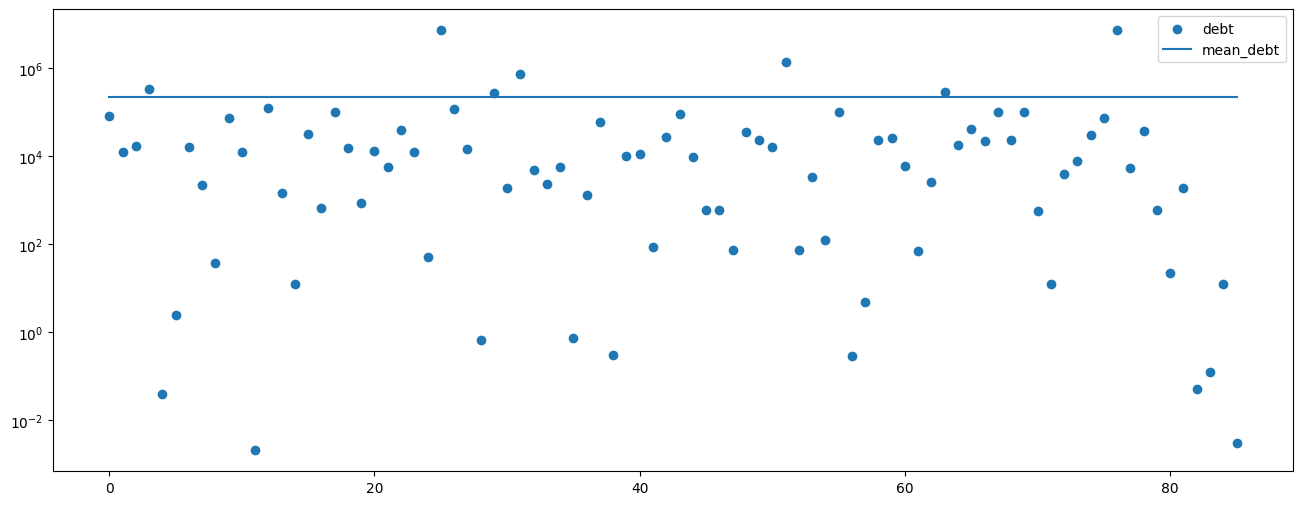

In [29]:
# Calculate mean debt and add as new column
all_user_snapshots_df['mean_debt'] = all_user_snapshots_df['debt'].mean()

plt.figure(figsize=(16, 6))

# Plot debt & mean debt
plt.scatter(all_user_snapshots_df.index, all_user_snapshots_df["debt"], label="debt")
plt.plot(all_user_snapshots_df.index, all_user_snapshots_df["mean_debt"], label="mean_debt")
plt.yscale("log")
plt.legend()
plt.show()

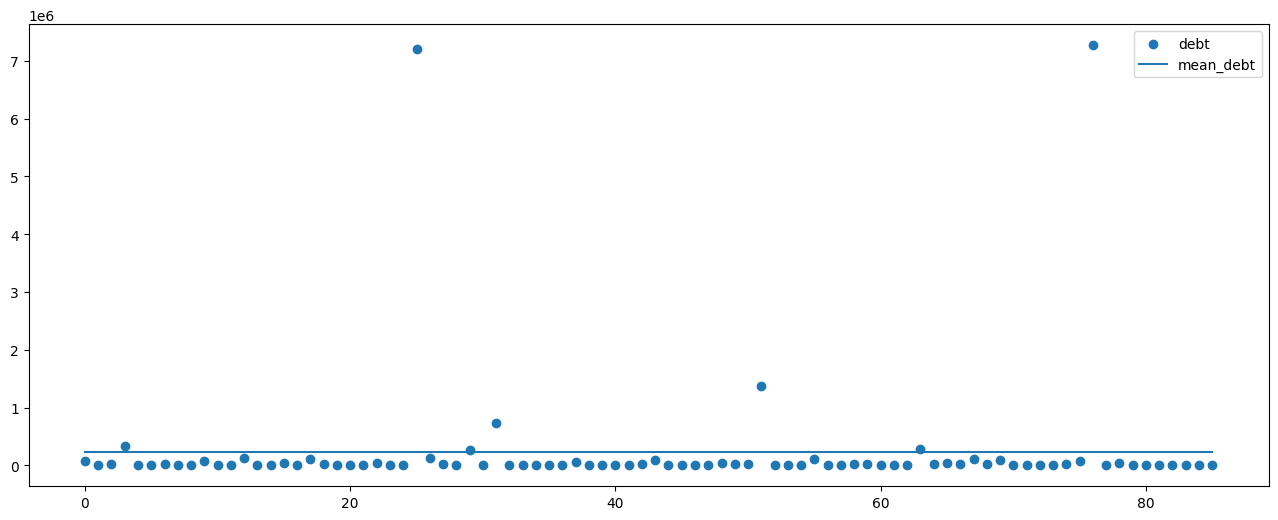

In [30]:
# Calculate mean debt and add as new column
all_user_snapshots_df['mean_debt'] = all_user_snapshots_df['debt'].mean()

plt.figure(figsize=(16, 6))

# Plot debt & mean debt
plt.scatter(all_user_snapshots_df.index, all_user_snapshots_df["debt"], label="debt")
plt.plot(all_user_snapshots_df.index, all_user_snapshots_df["mean_debt"], label="mean_debt")
# plt.yscale("log")
plt.legend()
plt.show()

---

In [31]:
converted_latest_row

{'rate': 0.07035060980774377,
 'minted': 351614229.13355106,
 'redeemed': 332535248.69229764,
 'total_collateral': 7689.747122719911,
 'total_collateral_usd': 29739692.90881451,
 'total_stablecoin': 0.017598543792083726,
 'total_debt': 19096482.887016036,
 'n_loans': 86.0,
 'amm_price': 3671.856344656012,
 'price_oracle': 3867.447451028194,
 'base_price': 2602.2924889987744,
 'min_band': -57.0,
 'max_band': 1034.0,
 'borrowable': 130921019.55874656,
 'loan_discount': 9e+16,
 'liquidation_discount': 6e+16,
 'sum_debt_squared': 107599600544808.17,
 'hhi': 107599600544808.17,
 'hhi_ideal': 4240414635512.748,
 'hhi_ratio': 25.37478284403603}

In [32]:
sum_squared_debt_exp = 0
debt_sum = 0    

for i in all_user_snapshots_df["debt"]:
    sum_squared_debt_exp += i**2
    debt_sum += i


In [33]:
print(sum_squared_debt_exp / 2831018226331.6646)


38.007385308936


In [34]:
print(sum_squared_debt_exp)
print(debt_sum)

107599600544808.17
19096482.887016032


In [35]:
hhii = (21187669.688076336**2)/178
print(hhii)

2522007566354.094


---

In [36]:
print(f"Date range: {users_df_24h['last'].min()} to {users_df_24h['last'].max()}")

Date range: 2025-01-12 12:00:11 to 2025-01-12 12:00:11


In [37]:
with open('soft_liquidation_events_raw.json', 'r') as file:
    df = json.load(file)


In [38]:
df[0]

{'address': '0x1681195C176239ac5E72d9aeBaCf5b2492E0C4ee',
 'blockHash': '0x52c213e7cc0cd9db5fb9186da2c7c1444ce1dc9dad2cadd5bbb92810359350a6',
 'blockNumber': 20554719,
 'logIndex': 285,
 'removed': False,
 'transactionHash': '0x1324097bde24c596a22450cb09592440431cae6ea9ebb57cfe49deb0c0816f4e',
 'transactionIndex': 84,
 'id': 'log_22ac0ca7',
 'returnValues': {'0': '0x28104d4F703EE5B5011cefe106f54eFd56F33f95',
  '1': '1',
  '2': '1299822141348955919',
  '3': '0',
  '4': '3394259846847306848305',
  'buyer': '0x28104d4F703EE5B5011cefe106f54eFd56F33f95',
  'sold_id': '1',
  'tokens_sold': '1299822141348955919',
  'bought_id': '0',
  'tokens_bought': '3394259846847306848305'},
 'event': 'TokenExchange',
 'signature': '0xb2e76ae99761dc136e598d4a629bb347eccb9532a5f8bbd72e18467c3c34cc98',
 'raw': {'data': '0x00000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000001209e559ce4ac70f0000000000000000000000000000000000000000000000000000000000000

In [39]:
new_df = []

for i in df:
    row = {}
    row["blockNumber"] = i["blockNumber"]
    row["transactionHash"] = i["transactionHash"]
    if i["returnValues"]["sold_id"] == "0" and i["returnValues"]["bought_id"] == "1":
        row["crvUSD"] = float(i["returnValues"]["tokens_sold"])/10**18
        row["collateral"] = float(i["returnValues"]["tokens_bought"])/10**18*-1
    else:
        row["crvUSD"] = float(i["returnValues"]["tokens_bought"])/10**18*-1
        row["collateral"] = float(i["returnValues"]["tokens_sold"])/10**18
    new_df.append(row)


In [40]:
type(df[0]["returnValues"]["sold_id"])



str

In [41]:
new_df[0]

{'blockNumber': 20554719,
 'transactionHash': '0x1324097bde24c596a22450cb09592440431cae6ea9ebb57cfe49deb0c0816f4e',
 'crvUSD': -3394.2598468473066,
 'collateral': 1.299822141348956}

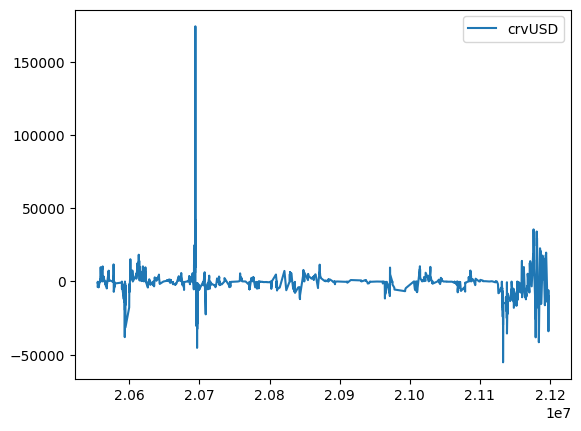

In [42]:
converted_df = pd.DataFrame(new_df)

# Plot crvUSD and collateral
plt.plot(converted_df["blockNumber"], converted_df["crvUSD"], label="crvUSD")
# plt.plot(converted_df["collateral"], label="collateral")
plt.legend()
plt.show()


In [43]:
converted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710 entries, 0 to 1709
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   blockNumber      1710 non-null   int64  
 1   transactionHash  1710 non-null   object 
 2   crvUSD           1710 non-null   float64
 3   collateral       1710 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 53.6+ KB


In [44]:
with open('big_price_oracle_results.json', 'r') as file:
    price_list = json.load(file)
    
price_df = pd.DataFrame(price_list)


In [45]:
price_df.info()
price_df["get_p_diff"] = price_df["get_p"].diff()
price_df["delta"] = price_df["get_p"]-price_df["price_oracle"]
price_df["abs_delta"] = price_df["delta"].abs()


# Join the two dataframes on blockNumber
joined_df = pd.merge(converted_df, price_df, on="blockNumber", how="inner")

joined_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648001 entries, 0 to 648000
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   blockNumber   648001 non-null  int64  
 1   price_oracle  647378 non-null  float64
 2   get_p         647751 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 14.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1487 entries, 0 to 1486
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   blockNumber      1487 non-null   int64  
 1   transactionHash  1487 non-null   object 
 2   crvUSD           1487 non-null   float64
 3   collateral       1487 non-null   float64
 4   price_oracle     1485 non-null   float64
 5   get_p            1487 non-null   float64
 6   get_p_diff       1487 non-null   float64
 7   delta            1485 non-null   float64
 8   abs_delta        1485 non-null   float64
dtypes:

In [46]:
# save joined_df to csv
joined_df.to_csv('joined_df.csv', index=False)



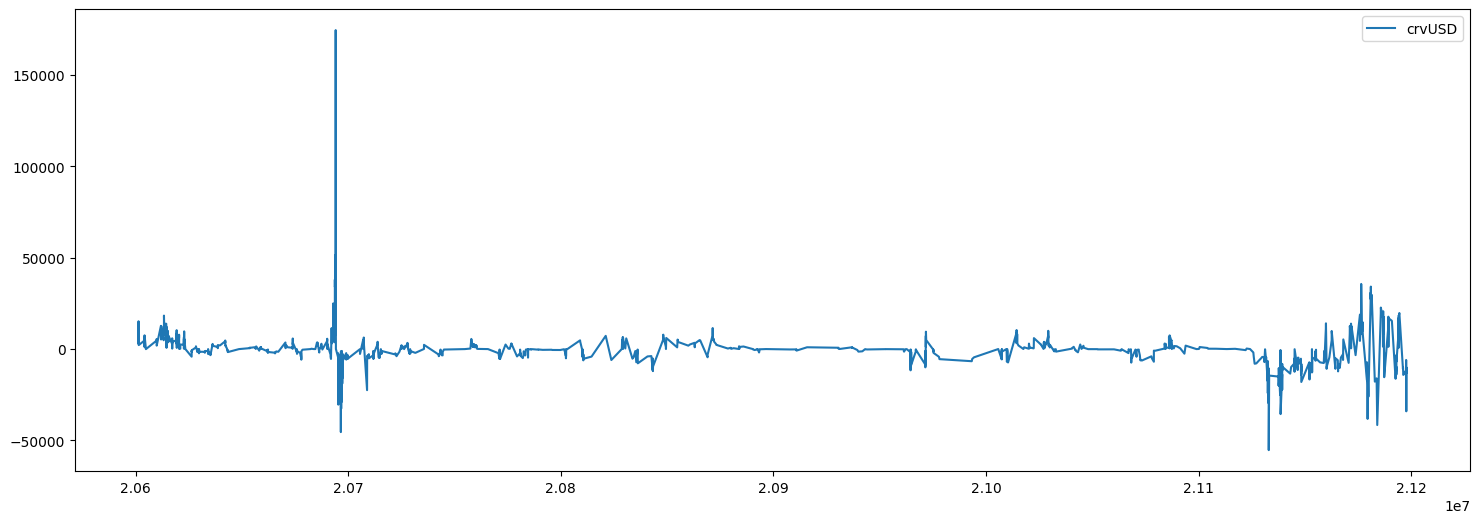

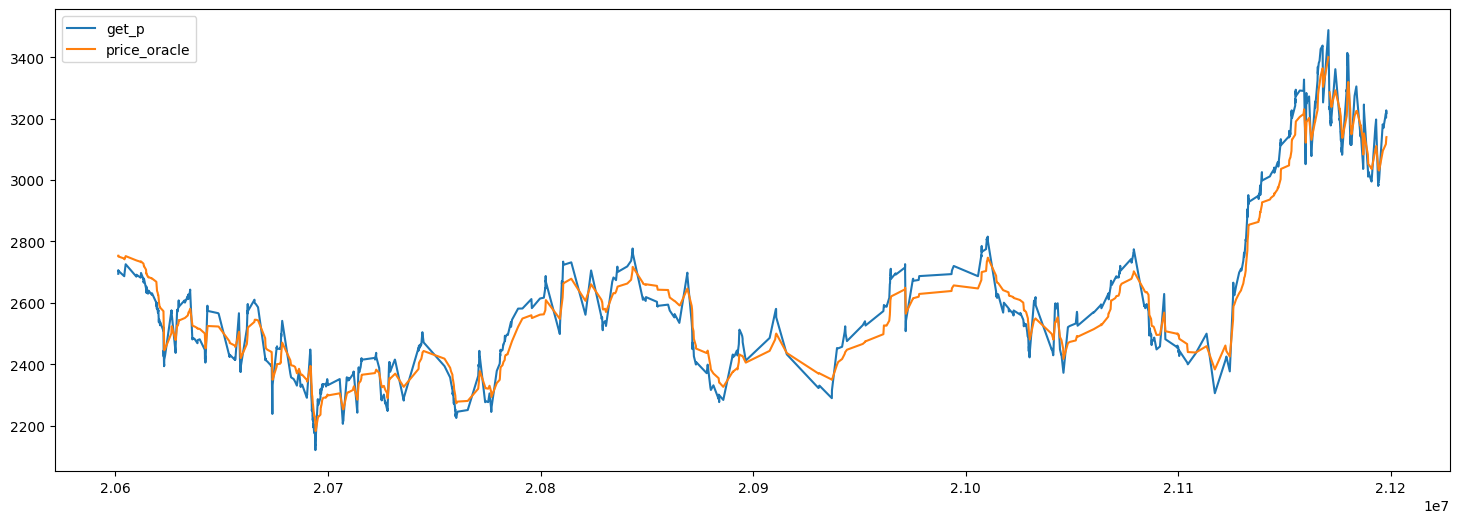

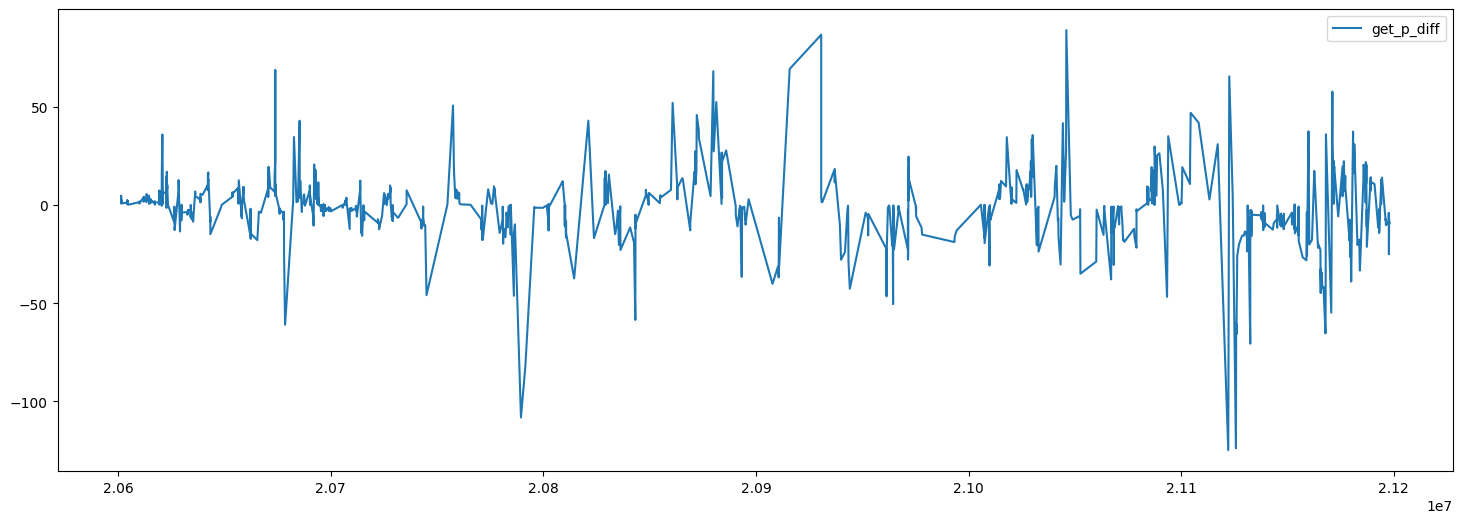

In [47]:
# Plot crvUSD and collateral
# Size of plot
plt.figure(figsize=(18, 6))
plt.plot(joined_df["blockNumber"], joined_df["crvUSD"], label="crvUSD")
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(joined_df["blockNumber"], joined_df["get_p"], label="get_p")
plt.plot(joined_df["blockNumber"], joined_df["price_oracle"], label="price_oracle")
plt.legend()
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(joined_df["blockNumber"], joined_df["get_p_diff"], label="get_p_diff")
plt.legend()
plt.show()

In [48]:
# Create a new column for incentive
joined_df['incentive'] = 0.0

# Iterate through the dataframe
for idx, row in joined_df.iterrows():
    if row['crvUSD'] > 0:
        joined_df.at[idx, 'incentive'] = -1 * row['collateral'] * row['price_oracle'] - row['crvUSD']
    else:
        joined_df.at[idx, 'incentive'] = -1 * row['crvUSD'] - row['collateral'] * row['price_oracle']

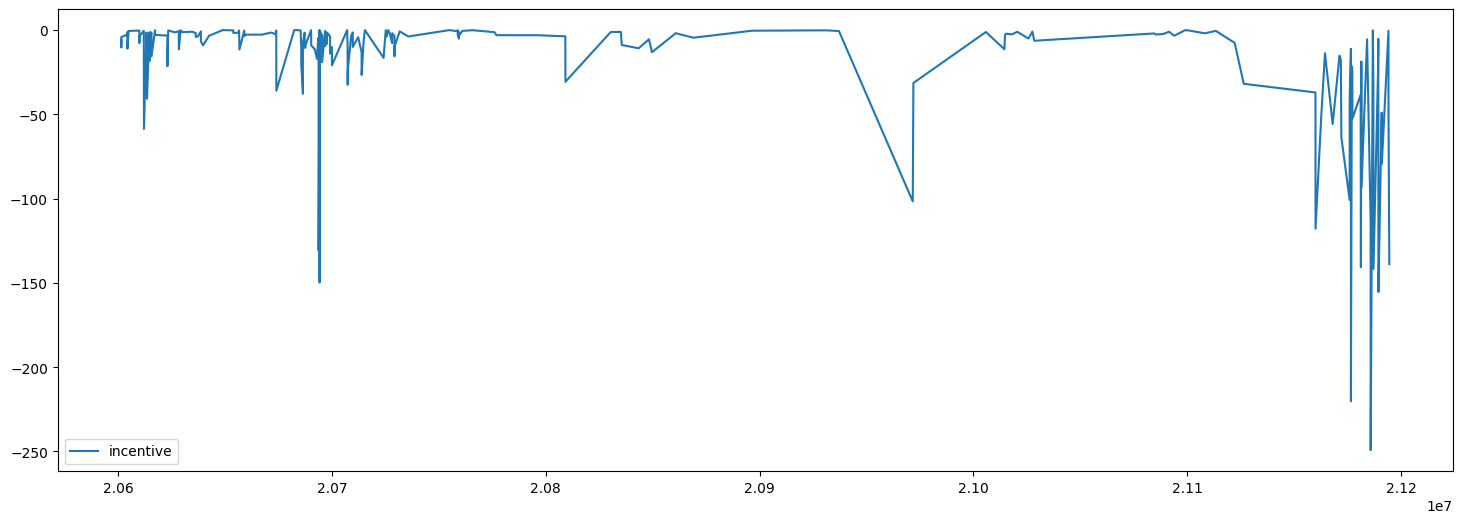

In [49]:
masked_df = joined_df[joined_df["incentive"] < 0]


plt.figure(figsize=(18, 6))
plt.plot(masked_df["blockNumber"], masked_df["incentive"], label="incentive")
plt.legend()
plt.show()

In [50]:
sorted_df = masked_df.sort_values(by="incentive", ascending=False)

# Convert masked_df to list of dictionaries
masked_df_list = sorted_df.to_dict(orient='records')


In [51]:
masked_df_list[-3]

{'blockNumber': 21189381,
 'transactionHash': '0x76cc40b1cb21e6acb61dd0c7b9496500188d29392bf689096236d115b6495d63',
 'crvUSD': 16897.328191183795,
 'collateral': -5.484949415615651,
 'price_oracle': 3052.3453832046703,
 'get_p': 3028.022660052322,
 'get_p_diff': 11.702826288401411,
 'delta': -24.322723152348317,
 'abs_delta': 24.322723152348317,
 'incentive': -155.36816531821023}

In [52]:
masked_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 5 to 1475
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   blockNumber      258 non-null    int64  
 1   transactionHash  258 non-null    object 
 2   crvUSD           258 non-null    float64
 3   collateral       258 non-null    float64
 4   price_oracle     258 non-null    float64
 5   get_p            258 non-null    float64
 6   get_p_diff       258 non-null    float64
 7   delta            258 non-null    float64
 8   abs_delta        258 non-null    float64
 9   incentive        258 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 22.2+ KB
